# dfGP + dfNN

In [ ]:
from GP_models import GP_predict
from NN_models import dfNN_for_vmap
from simulate import simulate_convergence, simulate_branching, simulate_ridge, simulate_merge, simulate_deflection
from metrics import compute_RMSE, compute_MAE, compute_NLL, compute_NLL_full
from utils import set_seed

# Global file for training configs
from configs import PATIENCE, GP_MAX_NUM_EPOCHS, NUM_RUNS, GP_LEARNING_RATE, WEIGHT_DECAY, N_SIDE, DFGPDFNN_RESULTS_DIR, SIGMA_F_RANGE, L_RANGE

import torch
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd

### TIMING ###
import time
start_time = time.time()  # Start timing after imports

# Set seed for reproducibility
set_seed(42)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu' # for now
print('Using device:', device)
print()

# stick to covention to keep df lower case
model_name = "dfGPdfNN"

#########################
### x_train & y_train ###
#########################

# Import all simulation functions
from simulate import (
    simulate_convergence,
    simulate_branching,
    simulate_merge,
    simulate_deflection,
    simulate_ridge,
)

# Define simulations as a dictionary with names as keys to function objects
simulations = {
    "convergence": simulate_convergence,
    "branching": simulate_branching,
    "merge": simulate_merge,
    "deflection": simulate_deflection,
    "ridge": simulate_ridge,
}

# Load training inputs
x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Storage dictionaries
y_train_dict = {}

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate training observations
    y_train = sim_func(x_train)
    y_train_dict[sim_name] = y_train  # Store training outputs

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Training inputs shape: {x_train.shape}")
    print(f"Training observations shape: {y_train.shape}")
    print(f"Training inputs dtype: {x_train.dtype}")
    print()

#######################
### x_test & y_test ###
#######################

print("=== Generating test data ===")

# Choose discretisation that is good for simulations and also for quiver plotting
N_SIDE = N_SIDE

side_array = torch.linspace(start = 0.0, end = 1.0, steps = N_SIDE)
XX, YY = torch.meshgrid(side_array, side_array, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
# long format
x_test = x_test_grid.reshape(-1, 2)

# Storage dictionaries
y_test_dict = {}

# Make y_test_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate test observations
    y_test = sim_func(x_test)
    y_test_dict[sim_name] = y_test  # Store test outputs

    # Print details
    print(f"=== {sim_name.upper()} ===")
    print(f"Test inputs shape: {x_test.shape}")
    print(f"Test observations shape: {y_test.shape}")
    print(f"Test inputs dtype: {x_test.dtype}")
    print()

    # visualise_v_quiver(y_test, x_test, title_string = name)

#####################
### Training loop ###
#####################

# Early stopping parameters
PATIENCE = PATIENCE
MAX_NUM_EPOCHS = GP_MAX_NUM_EPOCHS

# Number of training runs for mean and std of metrics
NUM_RUNS = NUM_RUNS
LEARNING_RATE = GP_LEARNING_RATE
WEIGHT_DECAY = WEIGHT_DECAY

# Pass in all the training data
# BATCH_SIZE = BATCH_SIZE

# Ensure the results folder exists
RESULTS_DIR = DFGPDFNN_RESULTS_DIR
os.makedirs(RESULTS_DIR, exist_ok = True)

### LOOP OVER SIMULATIONS ###
for sim_name, sim_func in simulations.items():
    print(f"\nTraining for {sim_name.upper()}...")

    # Store metrics for the current simulation
    simulation_results = []

    # x_train is the same, select y_train
    x_train = x_train.to(device)

    y_train = y_train_dict[sim_name].to(device)
    # select the correct y_test (PREVIOUS ERROR)
    y_test = y_test_dict[sim_name].to(device)

    ### LOOP OVER RUNS ###
    for run in range(NUM_RUNS):
        print(f"\n--- Training Run {run + 1}/{NUM_RUNS} ---")

        # Sample from uniform distributions to initialise hyperparameters
        sigma_n = torch.tensor([0.05], requires_grad = False).to(device) # no optimisation for noise, no sampling
        # nn.Parameter avoids the leaf problem
        sigma_f = nn.Parameter(torch.empty(1, device = device).uniform_( * SIGMA_F_RANGE)) # Trainable
        l = nn.Parameter(torch.empty(2, device = device).uniform_( * L_RANGE)) # Trainable
        
        # We do not need to "initialse" the GP model but the mean model
        # Initialise fresh model
        dfNN_mean_model = dfNN_for_vmap()
        dfNN_mean_model.to(device)
        # We don't need a criterion either

        # Define optimizer (e.g., AdamW)
        optimizer = optim.AdamW(list(dfNN_mean_model.parameters()) + [sigma_f, l], lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

        # Initialise tensors to store losses over epochs (for convergence plot)
        epoch_train_NLML_losses = torch.zeros(MAX_NUM_EPOCHS)
        epoch_train_RMSE_losses = torch.zeros(MAX_NUM_EPOCHS)
        epoch_test_RMSE_losses = torch.zeros(MAX_NUM_EPOCHS)

        epoch_sigma_f = torch.zeros(MAX_NUM_EPOCHS)
        epoch_l1 = torch.zeros(MAX_NUM_EPOCHS)
        epoch_l2 = torch.zeros(MAX_NUM_EPOCHS)

        # Early stopping variables
        best_loss = float('inf')
        epochs_no_improve = 0

        ### LOOP OVER EPOCHS ###
        print("\nStart Training")
        for epoch in range(MAX_NUM_EPOCHS):
            
            dfNN_mean_model.train()

            # No batching - full epoch pass in one
            if run == 0:
                mean_pred_train, _, lml_train = GP_predict(
                        x_train,
                        y_train,
                        x_train, # have predictions for training data again
                        [sigma_n, sigma_f, l], # initial hyperparameters
                        dfNN_mean_model, # vmap?
                        divergence_free_bool = True)
                
                loss = - lml_train
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Compute test loss for loss convergence plot
                mean_pred_test, _, _ = GP_predict(
                        x_train,
                        y_train,
                        x_test.to(device), # have predictions for training data again
                        [sigma_n, sigma_f, l], # initial hyperparameters
                        dfNN_mean_model,
                        divergence_free_bool = True)
                
                train_RMSE = compute_RMSE(y_train, mean_pred_train)
                test_RMSE = compute_RMSE(y_test, mean_pred_test)

                epoch_train_NLML_losses[epoch] = - lml_train
                epoch_train_RMSE_losses[epoch] = train_RMSE
                # epoch_test_NLML_losses[epoch] =  # train NLML
                epoch_test_RMSE_losses[epoch] = test_RMSE

                epoch_sigma_f[epoch] = sigma_f
                epoch_l1[epoch] = l[0]
                epoch_l2[epoch] = l[1]

                print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}, (RMSE): {train_RMSE:.4f}")
            
            else:
                # Save compute after run 1
                _, _, lml_train = GP_predict(
                        x_train,
                        y_train,
                        x_train[0:2], # have predictions for training data again
                        [sigma_n, sigma_f, l], # initial hyperparameters
                        dfNN_mean_model,
                        divergence_free_bool = True)
                
                loss = - lml_train
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                print(f"{sim_name} {model_name} Run {run + 1}/{NUM_RUNS}, Epoch {epoch + 1}/{MAX_NUM_EPOCHS}, Training Loss (NLML): {loss:.4f}")

            # Early stopping check
            if loss < best_loss:
                best_loss = loss
                epochs_no_improve = 0  # Reset counter
                # best_model_state = dfGP_model.state_dict()  # Save best model
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

        ################
        ### EVALUATE ###
        ################

        dfNN_mean_model.eval()

        # Now HPs should be tuned
        # Evaluate the trained model after all epochs are finished/early stopping

        mean_pred_test, covar_pred_test, _ = GP_predict(
                     x_train,
                     y_train,
                     x_test.to(device),
                     [sigma_n, sigma_f, l], # optimal hypers
                     dfNN_mean_model,
                     divergence_free_bool = True)

        # Only save things for one run
        if run == 0:
            #(1) Save predictions from first run so we can visualise them later
            torch.save(mean_pred_test, f"{RESULTS_DIR}/{sim_name}_{model_name}_test_mean_predictions.pt")
            torch.save(covar_pred_test, f"{RESULTS_DIR}/{sim_name}_{model_name}_test_covar_predictions.pt")

            #(2) Save best hyperparameters for run 1
            # Stack tensors into a single tensor
            best_hypers_tensor = torch.cat([
                sigma_n.reshape(-1),  # Ensure 1D shape
                sigma_f.reshape(-1),
                l.reshape(-1)
            ])

            # Save the tensor
            torch.save(best_hypers_tensor, f"{RESULTS_DIR}/{sim_name}_{model_name}_best_hypers.pt")

            #(3) Save loss over epochs
            df_losses = pd.DataFrame({
                'Epoch': list(range(epoch_train_NLML_losses.shape[0])), # pythonic
                'Train Loss NLML': epoch_train_NLML_losses.tolist(),
                'Train Loss RMSE': epoch_train_RMSE_losses.tolist(),
                'Test Loss RMSE': epoch_test_RMSE_losses.tolist(),
                'Sigma_f': epoch_sigma_f.tolist(),
                'l1': epoch_l1.tolist(),
                'l2': epoch_l2.tolist()
                })
            
            df_losses.to_csv(f"{RESULTS_DIR}/{sim_name}_{model_name}_losses_over_epochs.csv", index = False)

        mean_pred_train, covar_pred_train, _ = GP_predict(
                     x_train,
                     y_train,
                     x_train,
                     [sigma_n, sigma_f, l], # optimal hypers
                     dfNN_mean_model,
                     divergence_free_bool = True)

        ### Divergence
        # Need wrapper function for functional divergence
        def apply_GP(input):
            mean, _, _ = GP_predict(
                x_train,
                y_train,
                input,
                [sigma_n, sigma_f, l], # optimal hypers
                dfNN_mean_model,
                divergence_free_bool = True)
            return mean
        

        # functional div test
        jac_autograd_test = torch.autograd.functional.jacobian(apply_GP, 
                                        x_test.to(device))
        jac_autograd_test = torch.einsum("bobi -> boi", jac_autograd_test) # batch out batch in
        dfGPdfNN_test_div = torch.diagonal(jac_autograd_test, dim1 = -2, dim2 = -1).sum().item()

        # functional div train
        jac_autograd_train = torch.autograd.functional.jacobian(apply_GP, 
                                        x_train.to(device))
        jac_autograd_train = torch.einsum("bobi -> boi", jac_autograd_train) # batch out batch in
        dfGPdfNN_train_div = torch.diagonal(jac_autograd_train, dim1 = -2, dim2 = -1).sum().item()

        # Compute metrics (convert tensors to float) for every run's tuned model
        dfGPdfNN_train_RMSE = compute_RMSE(y_train, mean_pred_train).item()
        dfGPdfNN_train_MAE = compute_MAE(y_train, mean_pred_train).item()
        dfGPdfNN_train_NLL = compute_NLL_full(y_train, mean_pred_train, covar_pred_train).item()

        dfGPdfNN_test_RMSE = compute_RMSE(y_test, mean_pred_test).item()
        dfGPdfNN_test_MAE = compute_MAE(y_test, mean_pred_test).item()
        # full has cuased issues
        dfGPdfNN_test_NLL = compute_NLL(y_test, mean_pred_test, covar_pred_test).item()

        simulation_results.append([
            run + 1,
            dfGPdfNN_train_RMSE, dfGPdfNN_train_MAE, dfGPdfNN_train_NLL, dfGPdfNN_train_div,
            dfGPdfNN_test_RMSE, dfGPdfNN_test_MAE, dfGPdfNN_test_NLL, dfGPdfNN_test_div
        ])

    ### FINISH LOOP OVER RUNS ###
    # Convert results to a Pandas DataFrame
    df = pd.DataFrame(
        simulation_results, 
        columns = ["Run", 
                   "Train RMSE", "Train MAE", "Train NLL", "Train Divergence",
                   "Test RMSE", "Test MAE", "Test NLL", "Test Divergence"])

    # Compute mean and standard deviation for each metric
    mean_std_df = df.iloc[:, 1:].agg(["mean", "std"])  # Exclude "Run" column

    # Save results to CSV
    results_file = os.path.join(RESULTS_DIR, f"{sim_name}_{model_name}_metrics_per_run.csv")
    df.to_csv(results_file, index = False)
    print(f"\nResults saved to {results_file}")

    # Save mean and standard deviation to CSV
    mean_std_file = os.path.join(RESULTS_DIR, f"{sim_name}_{model_name}_metrics_summary.csv")
    mean_std_df.to_csv(mean_std_file)
    print(f"\nMean & Std saved to {mean_std_file}")
    # Only train for one simulation for now

### End timing ###
end_time = time.time()  # End timing
elapsed_time = end_time - start_time  # Compute elapsed time

print(f"Elapsed wall time: {elapsed_time:.4f} seconds")

# Define full path for the file
wall_time_path = os.path.join(RESULTS_DIR, "wall_time.txt")

# Save to the correct folder
with open(wall_time_path, "w") as f:
    f.write(f"Elapsed wall time: {elapsed_time:.4f} seconds\n")

print(f"Wall time saved to {wall_time_path}.")

Using device: cpu

=== CONVERGENCE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== BRANCHING ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== MERGE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== DEFLECTION ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== RIDGE ===
Training inputs shape: torch.Size([196, 2])
Training observations shape: torch.Size([196, 2])
Training inputs dtype: torch.float32

=== Generating test data ===
=== CONVERGENCE ===
Test inputs shape: torch.Size([400, 2])
Test observations shape: torch.Size([400, 2])
Test inputs dtype: torch.float32

=== BRANCHING ===
Test inputs shape: torch.Size([400, 2])
Test obse

In [8]:
wall_time_path = os.path.join(RESULTS_DIR, model_name + "_run_" "wall_time.txt")
gpu_name = torch.cuda.get_device_name(0)
gpu_name

'NVIDIA GeForce RTX 4090'

In [11]:
import torch

A = torch.randn(4, 4)
A - A.T

tensor([[ 0.0000,  2.6897, -0.4457,  0.8486],
        [-2.6897,  0.0000, -1.0157, -0.8175],
        [ 0.4457,  1.0157,  0.0000, -1.0308],
        [-0.8486,  0.8175,  1.0308,  0.0000]])

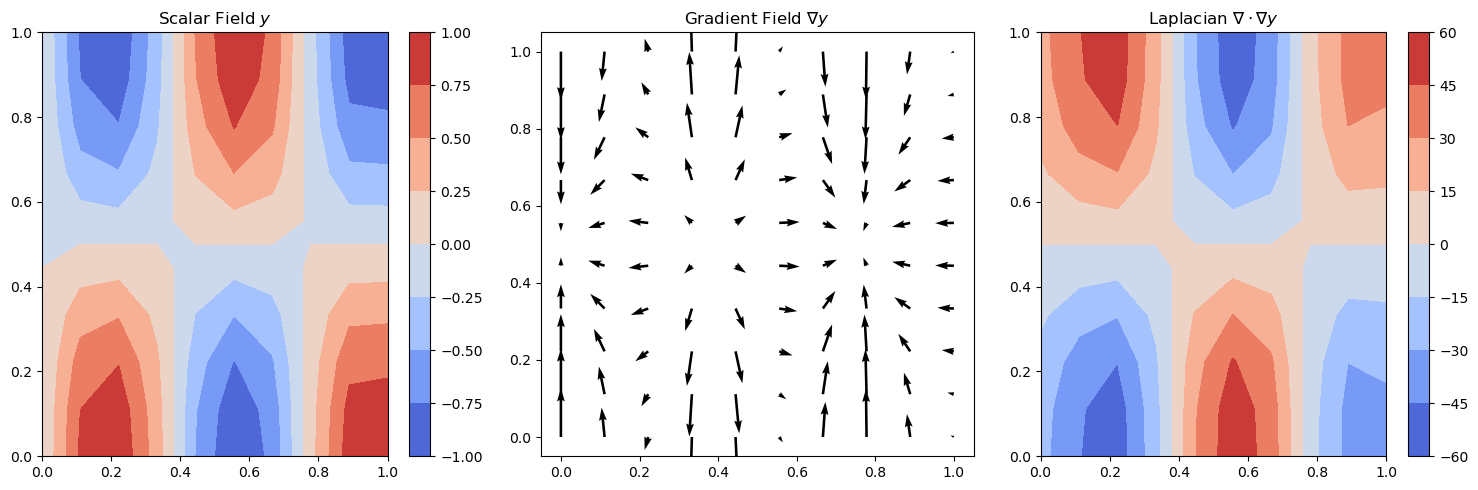

In [13]:
import torch
import matplotlib.pyplot as plt

# Create a uniform grid
x = torch.linspace(0.0, 1.0, steps=10)
XX, YY = torch.meshgrid(x, x, indexing="xy")

# Define scalar field y (potential field)
y = torch.sin(2 * 4.1415 * XX) * torch.cos(1 * 3.1415 * YY)

# Compute gradient (∇y)
dy_dx, dy_dy = torch.gradient(y, spacing=(x, x))

# Compute second derivatives (for Laplacian)
d2y_dx2, _ = torch.gradient(dy_dx, spacing=(x, x))
_, d2y_dy2 = torch.gradient(dy_dy, spacing=(x, x))

# Compute divergence of the gradient field (Laplacian)
laplacian_y = d2y_dx2 + d2y_dy2

# Plot the scalar field y
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.contourf(XX, YY, y, cmap="coolwarm")
plt.colorbar()
plt.title("Scalar Field $y$")

# Plot the gradient field (∇y) as quiver plot
plt.subplot(1, 3, 2)
plt.quiver(XX, YY, dy_dx, dy_dy)
plt.title("Gradient Field $\\nabla y$")

# Plot the Laplacian (divergence of gradient field)
plt.subplot(1, 3, 3)
plt.contourf(XX, YY, laplacian_y, cmap="coolwarm")
plt.colorbar()
plt.title("Laplacian $\\nabla \\cdot \\nabla y$")

plt.tight_layout()
plt.show()

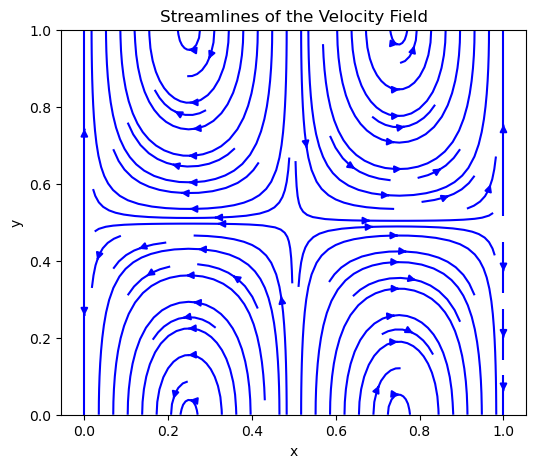

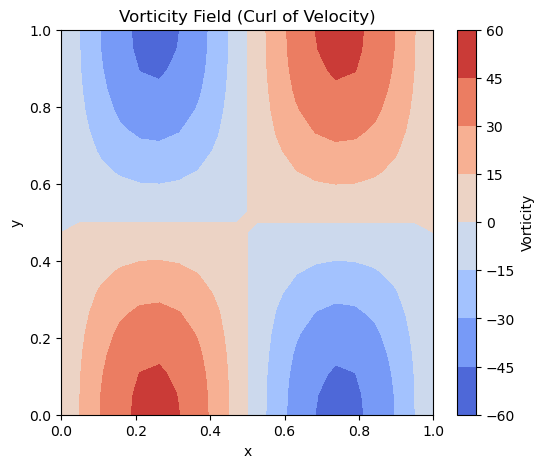

In [16]:
import torch
import matplotlib.pyplot as plt

# Define grid
x = torch.linspace(0.0, 1.0, steps=20)
XX, YY = torch.meshgrid(x, x, indexing="xy")

# Define stream function
psi = torch.sin(2 * torch.pi * XX) * torch.cos(torch.pi * YY)

# Compute velocity components
u = -torch.pi * torch.sin(2 * torch.pi * XX) * torch.sin(torch.pi * YY)
v = -2 * torch.pi * torch.cos(2 * torch.pi * XX) * torch.cos(torch.pi * YY)

# Compute vorticity (curl)
dv_dx = 4 * torch.pi**2 * torch.sin(2 * torch.pi * XX) * torch.cos(torch.pi * YY)
du_dy = -torch.pi**2 * torch.sin(2 * torch.pi * XX) * torch.cos(torch.pi * YY)
vorticity = dv_dx - du_dy  # Curl of velocity field

# Plot streamlines
plt.figure(figsize=(6, 5))
plt.streamplot(XX.numpy(), YY.numpy(), u.numpy(), v.numpy(), color="blue")
plt.title("Streamlines of the Velocity Field")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot vorticity
plt.figure(figsize=(6, 5))
plt.contourf(XX.numpy(), YY.numpy(), vorticity.numpy(), cmap="coolwarm")
plt.colorbar(label="Vorticity")
plt.title("Vorticity Field (Curl of Velocity)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()